<a href="https://colab.research.google.com/github/IAMPathak2702/Miscellaneous_machine_learning_project-/blob/main/SKIMLIT_MILESTONE_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SkimLit Learn**

SkimLit is a project that aims to summarize biomedical research papers using natural language processing (NLP) techniques. The goal is to create concise summaries of scientific literature to assist researchers and practitioners in keeping up with the latest developments in their fields. SkimLit utilizes advanced NLP models to extract key information from research papers and generate summaries that capture the main points of the articles. This project can be valuable for quickly understanding the content of a large number of papers, facilitating literature review processes, and aiding in research exploration and discovery.

In [ ]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow import keras
from keras import Sequential,layers

from sklearn.model_selection import train_test_split

import random
import os


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign


dev.txt  test.txt  train.txt


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

filenames = [data_dir + filenames for filenames in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
def get_lines(filename):
    """
    Reads the contents of a text file and returns a list of its lines.

    Parameters:
    filename (str): The name of the file to be read.

    Returns:
    list of str: A list containing each line of the file as a string.

    Example:
    >>> lines = get_lines("sample.txt")
    >>> print(lines)
    ['Line 1\n', 'Line 2\n', 'Line 3\n']
    """
    # Open the file in 'r' mode
    with open(data_dir + str(filename), 'r') as file:
        file_list = []
        # Iterate over each line in the file
        for line in file:
            file_list.append(str(line))
    return file_list


In [ ]:
train_lines = get_lines('train.txt')
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
%%time

train_samples = preprocess_text_with_line_numbers('train.txt')
val_samples = preprocess_text_with_line_numbers('dev.txt')
test_samples = preprocess_text_with_line_numbers('test.txt')

CPU times: user 499 ms, sys: 68.2 ms, total: 567 ms
Wall time: 597 ms


In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

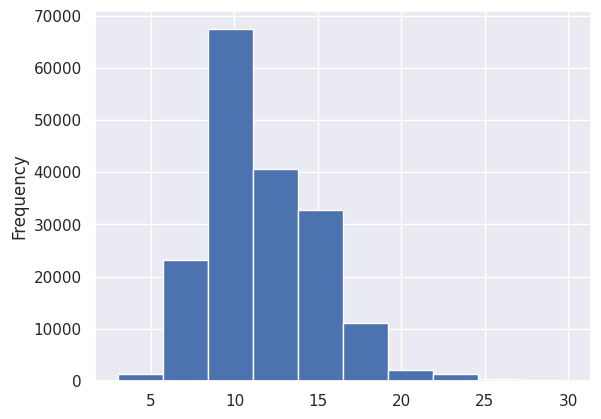

In [ ]:
train_df['total_lines'].plot(kind='hist');

In [ ]:
train_df.value_counts('target')

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
dtype: int64

## Make Numerical Models("ML Model requires numerical labels") using One hot encoder

In [ ]:
labels = train_df['target'].unique().tolist()
labels

['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND']

In [ ]:
# One hot encoding labels

# Convert labels to categorical integers
train_label_indices = tf.range(len(train_df['target'].to_numpy().reshape(-1,1)), dtype=tf.int32)
val_label_indices = tf.range(len(val_df['target'].to_numpy().reshape(-1,1)), dtype=tf.int32)
test_label_indices = tf.range(len(test_df['target'].to_numpy().reshape(-1,1)), dtype=tf.int32)

# Use tf.one_hot to one-hot encode the labels
train_one_hot_tf_labels = tf.one_hot(train_label_indices, depth=len(labels))
val_one_hot_tf_labels = tf.one_hot(val_label_indices, depth=len(labels))
test_one_hot_tf_labels = tf.one_hot(test_label_indices, depth=len(labels))


In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output =False)
train_one_hot_labels= one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_one_hot_labels= one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_one_hot_labels= one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

In [ ]:
train_one_hot_labels == train_one_hot_tf_labels

<tf.Tensor: shape=(180040, 5), dtype=bool, numpy=
array([[False,  True,  True, False,  True],
       [ True, False, False,  True,  True],
       [ True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True, False],
       [ True, False,  True,  True,  True],
       [ True, False,  True,  True,  True]])>

In [ ]:
tf.constant(train_one_hot_labels)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [ ]:
train_df['target'].to_numpy().reshape(-1,1)[:10]

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ['METHODS'],
       ['METHODS'],
       ['METHODS'],
       ['RESULTS'],
       ['RESULTS'],
       ['RESULTS'],
       ['RESULTS']], dtype=object)

## ONe hot encoding by Pandas DataFrame

In [ ]:
pd_one_hot = pd.get_dummies((train_df['target'])).to_numpy()

In [ ]:
pd_one_hot_tensor = tf.constant(pd_one_hot)
pd_one_hot_tensor

<tf.Tensor: shape=(180040, 5), dtype=uint8, numpy=
array([[0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)>

## Label Encode Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_label_encoder = label_encoder.fit_transform(train_df['target'].to_numpy())
val_label_encoder = label_encoder.fit_transform(val_df['target'].to_numpy())
test_label_encoder = label_encoder.fit_transform(test_df['target'].to_numpy())

In [ ]:
train_label_encoder.shape , train_label_encoder

((180040,), array([3, 2, 2, ..., 4, 1, 1]))

In [ ]:
# Get class names and number of classes from the labelEncoder instance

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experments(model) we are running
>0. Naive Bayes with TF-IDF encoder (baseline)

>1. Conv1D with token embedding

>2. Tensrflow HUb pretrained Feature Extractor

>3. Conv1D with Character Embedding

>4. Pretrained token Embedding (same as model_2) + Character Embedding(same as model_3)

>5. Pretrained token Embedding + Character Embedding + positional embeddings

## Model_0 - Naive Bayes with TF-IDF encoder (a baseline model)

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_label_encoder)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_sentences,
              y=val_label_encoder)

0.7218323844829869

In [ ]:
# Making predictions using our base line model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
from helper_functions import calculate_results

model_0_results = calculate_results(val_label_encoder,baseline_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing our data(the text) for deep learning models (getting one with the data)

In [ ]:
sen_words_len = [len(sentences.split()) for sentences in train_sentences]
avg_sen_len = np.round(np.mean(sen_words_len))
avg_sen_len

26.0

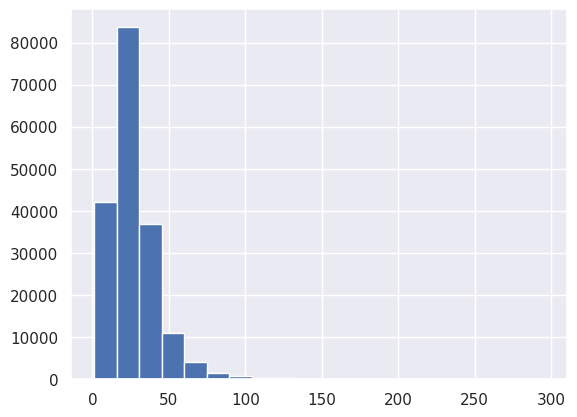

In [ ]:
# what's the distribution look like?
plt.hist(sen_words_len,bins = 20);

In [ ]:

# How long of a sentence length covers 95% of examples?
np.percentile(sen_words_len, 95)

55.0

In [ ]:
#Maximum sequence length of training set?
max(sen_words_len)

296

In [ ]:
total_words = np.unique(sen_words_len)
len(total_words)

193

In [ ]:
# How many unique words are in colab ? # taken from the papers
max_tokens = 68000

### Creating a Text Vectorizing layer

In [ ]:
# Intitaing out text_vectorizer layers
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens, #number words in vocabulary
                                           output_sequence_length=55,# desired output length
                                           )


In [ ]:
# Adapting the text vecotrizer layers for Train_sentences.

text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences

target_sentences = random.choice(train_sentences)
print(f'''
Text----------->: {target_sentences},\n
length of Text  : {len(target_sentences.split())},\n
Vecotrized_text : {text_vectorizer([target_sentences])}


      ''')


Text----------->: sws was positively correlated with percent negative urines ( p = @ ) and participants with increased sws had greater percent negative urines ( p = @ ) and maximum consecutive number of days abstinent ( p = @ ) .,

length of Text  : 41,

Vecotrized_text : [[10947    10  1520   752     7   795   469 15293    14     3    60     7
     96 10947    55   182   795   469 15293    14     3   635   753   154
      4    84  5601    14     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


      


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"""
Total words : {len(rct_20k_text_vocab)},
Top Unique words : {rct_20k_text_vocab[:5]}
Least unique words : {rct_20k_text_vocab[-5:]}

""")


Total words : 64841,
Top Unique words : ['', '[UNK]', 'the', 'and', 'of']
Least unique words : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']




In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Creating Embedding layer

In [ ]:
embedding  = layers.Embedding(input_dim= len(rct_20k_text_vocab),
                              output_dim=128,
                              mask_zero = True,
                              name = 'token_embedding')

In [ ]:
vectorized_sentence = text_vectorizer([target_sentences])
embedded_sentence = embedding(vectorized_sentence)


print(f"""
Target Sentence : {target_sentences},\n
Vectorized sentence : {vectorized_sentence},\n
Embedded Sentence : {embedded_sentence}""")


Target Sentence : sws was positively correlated with percent negative urines ( p = @ ) and participants with increased sws had greater percent negative urines ( p = @ ) and maximum consecutive number of days abstinent ( p = @ ) .,

Vectorized sentence : [[10947    10  1520   752     7   795   469 15293    14     3    60     7
     96 10947    55   182   795   469 15293    14     3   635   753   154
      4    84  5601    14     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]],

Embedded Sentence : [[[ 0.00474066  0.01921901 -0.00562391 ...  0.01838512  0.02319305
   -0.03908777]
  [-0.00898824  0.03428615 -0.04044648 ... -0.04675451  0.03280303
    0.01802799]
  [ 0.03338009 -0.00522256 -0.02825867 ... -0.04514095  0.04748297
   -0.04399389]
  ...
  [-0.04041251 -0.02832712 -0.04872869 ...  0.03361876  0.01011562
   -0.01469069]
  [-0.04041251 -0.02832712 -0.04872869 ... 

## Tensorflow API `tf.data.API`  Creating Datasets ~(making sure data load as fast as possible)


In [ ]:
train_datasets = tf.data.Dataset.from_tensor_slices((train_sentences,train_one_hot_labels))
val_datasets = tf.data.Dataset.from_tensor_slices((val_sentences,val_one_hot_labels))
test_datasets = tf.data.Dataset.from_tensor_slices((test_sentences,test_one_hot_labels))

## Prefecthing and multithreding

In [ ]:
train_datasets = train_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
val_datasets = val_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
test_datasets = test_datasets.batch(32).prefetch(tf.data.AUTOTUNE)


## Model_1 ~ Conv1D with token embedding

In [ ]:
num_classes

5

In [ ]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:

# Fit the model
model_1_history = model_1.fit(train_datasets,
                              steps_per_epoch=int(0.1 * len(train_datasets)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_datasets,
                              validation_steps=int(0.1 * len(val_datasets))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 28s 48ms/step - loss: 0.9102 - accuracy: 0.6399 - val_loss: 0.6822 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6592 - accuracy: 0.7531 - val_loss: 0.6343 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6202 - accuracy: 0.7732 - val_loss: 0.5973 - val_accuracy: 0.7842


In [ ]:
model_1.evaluate(val_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.6004 - accuracy: 0.7840


[0.6004003882408142, 0.7840262055397034]

In [ ]:
model_1_preds = model_1.predict(val_datasets)

945/945 [==============================] - 3s 3ms/step


In [ ]:
model_1_preds.shape, model_1_preds

((30212, 5),
 array([[4.06177044e-01, 2.11196035e-01, 9.47872549e-02, 2.61480242e-01,
         2.63593756e-02],
        [4.62062925e-01, 2.75319040e-01, 1.31671969e-02, 2.42665097e-01,
         6.78572105e-03],
        [1.38125002e-01, 7.17318105e-03, 1.52245956e-03, 8.53143692e-01,
         3.56242635e-05],
        ...,
        [2.81080293e-06, 7.14687339e-04, 5.63683629e-04, 2.41896282e-06,
         9.98716474e-01],
        [5.58454767e-02, 4.25886244e-01, 1.19663596e-01, 7.19641671e-02,
         3.26640546e-01],
        [1.89087495e-01, 6.56330884e-01, 4.52717319e-02, 4.57684733e-02,
         6.35413826e-02]], dtype=float32))

In [ ]:
model_1_pred_classes = tf.argmax(model_1_preds, axis = 1)
model_1_pred_classes

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(val_label_encoder,model_1_pred_classes)
model_1_results

{'accuracy': 78.40262147491063,
 'precision': 0.7808076874079573,
 'recall': 0.7840262147491063,
 'f1': 0.78148039680367}

## Model_2 - Feature extraction Model

https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
import tensorflow_hub as hub
embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                 trainable=False,
                                 name = 'Universal_sentence_encoder')

In [ ]:
target_sentences = random.choice(train_sentences)
use_embedded_sentence = embedding_layer([target_sentences])
print(f"""
Target Sentence : {target_sentences},
Embedded layer sentences : {use_embedded_sentence.shape}""")


Target Sentence : to be eligible for inclusion , participants had to have at least one measurable lesion by ct or mri according to response evaluation criteria in solid tumors ( recist ) ; eastern cooperative oncology group performance status @-@ ; adequate bone marrow , liver , and renal function ; and serum thyroid-stimulating hormone concentration lower than @ miu/l .,
Embedded layer sentences : (1, 512)


In [ ]:
inputs = layers.Input(shape = [],dtype = tf.string)
x = embedding_layer(inputs)
outputs = layers.Dense(num_classes,activation ='softmax' )(x)

model_2 = tf.keras.Model(inputs,outputs, name = "Model_2_feature_extraction_model")

model_2.summary()

Model: "Model_2_feature_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None,)]                 0         
                                                                 
 Universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_11 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 256800389 (979.62 MB)
Trainable params: 2565 (10.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_2.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_2_history = model_2.fit(train_datasets,
                              steps_per_epoch=int(0.1 * len(train_datasets)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_datasets,
                              validation_steps=int(0.1 * len(val_datasets))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 1.2584 - accuracy: 0.5477 - val_loss: 1.0847 - val_accuracy: 0.5997
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 1.0112 - accuracy: 0.6269 - val_loss: 0.9549 - val_accuracy: 0.6506
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.9309 - accuracy: 0.6576 - val_loss: 0.8952 - val_accuracy: 0.6735


In [ ]:
model_2.evaluate(val_datasets)

945/945 [==============================] - 11s 12ms/step - loss: 0.8932 - accuracy: 0.6749


[0.8931803107261658, 0.6748973727226257]

In [ ]:
## making predictions with model_2
model_2_preds = model_2.predict(val_datasets)
model_2_preds_classes = tf.argmax(model_2_preds, axis =1)# converting probs  into classes
# Calculating results
model_2_results = calculate_results(val_label_encoder,model_2_preds_classes)
model_2_results

945/945 [==============================] - 10s 11ms/step


{'accuracy': 67.48973917648617,
 'precision': 0.6703372208409041,
 'recall': 0.6748973917648616,
 'f1': 0.6592951312830357}

## Model _ 3 - Model with character embeddings

## Creating a Character level tokenizer

In [ ]:
# Make functions to split sentences into characters
def split_char(text):
    return " ".join(list(text))

In [ ]:
# Test splitting our function
split_char(train_sentences[42])

's e c o n d a r y   e n d p o i n t s   w e r e   t h e   r e l a t i v e   r e d u c t i o n   o f   s l o u g h y   t i s s u e   a n d   t h e   p e r c e n t a g e   o f   p a t i e n t s   p r e s e n t i n g   w i t h   a   d e b r i d e d   w o u n d   .'

In [ ]:
train_chars = [split_char(sentences) for sentences in train_sentences]
val_chars = [split_char(sentences) for sentences in val_sentences]
test_chars = [split_char(sentences) for sentences in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average length of character?
chars_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_len)
mean_char_len

149.3662574983337

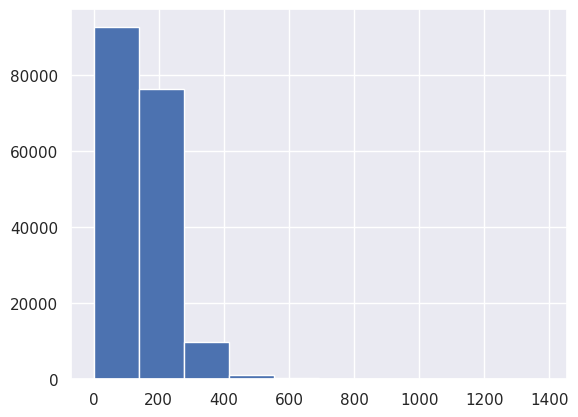

In [ ]:
plt.hist(chars_len , bins = 10);

max_tokens = 300 #from visualization



In [ ]:
np.percentile(chars_len , 95)

290.0

In [ ]:
import string
alphabets = string.ascii_lowercase +string.digits+string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
max_token = len(alphabets)+2 ## add two for space and [unk] as unknown character
max_token

70

In [ ]:
char_vectorizer = layers.TextVectorization(max_tokens = max_token,
                                           output_sequence_length=290,
                                           name = "char_vectorizer",
                                           )

char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"""
Total words : {len(char_vocab)},
Top Unique words : {char_vocab[:5]}
Least unique words : {char_vocab[-5:]}

""")


Total words : 28,
Top Unique words : ['', '[UNK]', 'e', 't', 'i']
Least unique words : ['k', 'x', 'z', 'q', 'j']




In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"""
Total words : {len(char_vocab)},
Top Unique words : {char_vocab[:5]}
Least unique words : {char_vocab[-5:]}

""")


Total words : 28,
Top Unique words : ['', '[UNK]', 'e', 't', 'i']
Least unique words : ['k', 'x', 'z', 'q', 'j']




## Character Embedding

In [ ]:
char_embedding_layer  = layers.Embedding(input_dim= len(char_vocab),
                              output_dim=25,
                              mask_zero = True,
                              name = 'char_embedding')

In [ ]:
target_chars = random.choice(train_chars)

vectorized_char = char_vectorizer([target_chars])
embedded_char = char_embedding_layer(vectorized_char)


print(f"""
Target_char : {target_chars},\n
Vectorized_char : {vectorized_char},\n
Embedded_char : {embedded_char.shape}""")


Target_char : t h e   o u t c o m e   m e a s u r e s   w i l l   i n c l u d e   a   g l o b a l   s h i f t   i n   t h e   r a n k i n   s c a l e   s c o r e s   a n d   d i c h o t o m i z e d   s c o r e s   ,   c h a n g e s   i n   q u a l i t y   o f   l i f e   ,   g e n e r a l   h e a l t h   ,   d e p r e s s i o n   ,   a n d   c a r e g i v e r   b u r d e n   a t   @   m o n t h s   p o s t r a n d o m i z a t i o n   .,

Vectorized_char : [[ 3 13  2  7 16  3 11  7 15  2 15  2  5  9 16  8  2  9 20  4 12 12  4  6
  11 12 16 10  2  5 18 12  7 22  5 12  9 13  4 17  3  4  6  3 13  2  8  5
   6 23  4  6  9 11  5 12  2  9 11  7  8  2  9  5  6 10 10  4 11 13  7  3
   7 15  4 25  2 10  9 11  7  8  2  9 11 13  5  6 18  2  9  4  6 26 16  5
  12  4  3 19  7 17 12  4 17  2 18  2  6  2  8  5 12 13  2  5 12  3 13 10
   2 14  8  2  9  9  4  7  6  5  6 10 11  5  8  2 18  4 21  2  8 22 16  8
  10  2  6  5  3 15  7  6  3 13  9 14  7  9  3  8  5  6 10  7 15  4 25  5
   3  4  7  6  0  0  

In [ ]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs) # vectorize text inputs
char_embeddings = char_embedding_layer(char_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs ,name = 'Model_3_Character_embedding')

# Compile
model_3.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "Model_3_Character_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 5) 

In [ ]:
train_char_datasets = tf.data.Dataset.from_tensor_slices((train_chars,train_one_hot_labels))
val_char_datasets = tf.data.Dataset.from_tensor_slices((val_chars,val_one_hot_labels))
test_char_datasets = tf.data.Dataset.from_tensor_slices((test_chars,test_one_hot_labels))




train_char_datasets = train_char_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_datasets = val_char_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_datasets = test_char_datasets.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3_history = model_3.fit(train_char_datasets,
                              steps_per_epoch=int(0.1 * len(train_char_datasets)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_datasets,
                              validation_steps=int(0.1 * len(val_char_datasets))) # only validate on 10% of batch

Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.2409 - accuracy: 0.4986 - val_loss: 1.5598 - val_accuracy: 0.3614
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0098 - accuracy: 0.6014 - val_loss: 1.5821 - val_accuracy: 0.3674
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9237 - accuracy: 0.6446 - val_loss: 1.6593 - val_accuracy: 0.3674


In [ ]:
model_3.evaluate(val_char_datasets)

945/945 [==============================] - 6s 6ms/step - loss: 0.8868 - accuracy: 0.6558


[0.8867931962013245, 0.6557658910751343]

In [ ]:
## making predictions with model_2
model_3_preds = model_3.predict(val_char_datasets)
model_3_preds_classes = tf.argmax(model_3_preds, axis =1)# converting probs  into classes
# Calculating results
model_3_results = calculate_results(val_label_encoder,model_3_preds_classes)
model_3_results

945/945 [==============================] - 4s 4ms/step


{'accuracy': 65.57659208261619,
 'precision': 0.652040767373586,
 'recall': 0.6557659208261618,
 'f1': 0.6451774640908629}

## Model_4 (Multi-Modal Model)

In [ ]:
# 1. Token Model
token_inputs = layers.Input(shape=[],dtype = tf.string)
token_embeddings = embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_outputs)

# 2. Setup char/model
char_inputs = layers.Input(shape = [], dtype = tf.string , name = 'Char_input_layer')
char_vectors = char_vectorizer(char_inputs)
char_embedd = char_embedding_layer(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedd)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. concatinate the token and char inputs
token_char_concat = layers.Concatenate(name='Token_char_hybrid')([token_model.output,char_model.output])

# 4. create ouput layers adding in dropouts
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128 , activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation='softmax')(final_dropout)


model_4 = tf.keras.Model(inputs =[token_model.input,char_model.input],
                         outputs = output_layer,
                         name = "Model_4_token_char_embeddings")

model_4.summary()

Model: "Model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Char_input_layer (InputLay  [(None,)]                    0         []                            
 er)                                                                                              
                                                                                                  
 input_9 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['Char_input_layer[0][0]']    
 rization)                                                                                        
                                                                      

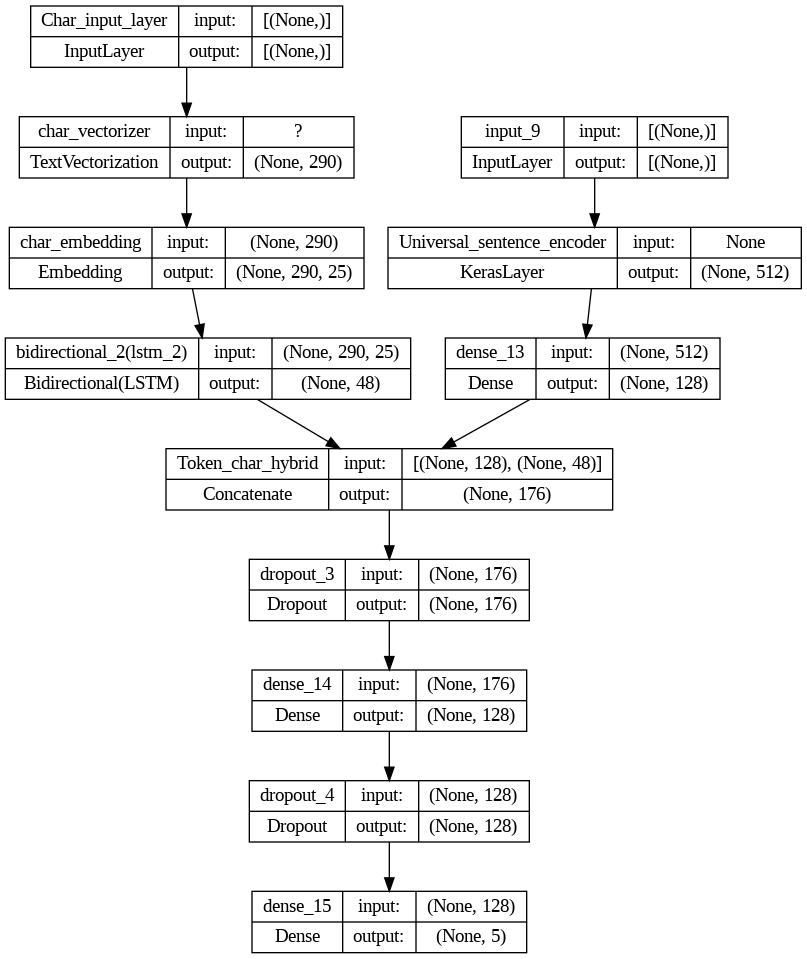

In [ ]:
from keras.utils import plot_model
plot_model(model_4,show_shapes = True)

In [ ]:
model_4.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [ ]:
## COmbining token and character data into a tf.DataSet
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_label = tf.data.Dataset.from_tensor_slices((train_one_hot_labels))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_label))


train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_label = tf.data.Dataset.from_tensor_slices((val_one_hot_labels))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_label))


val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_char_token_dataset , val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_4 = model_4.fit((train_char_token_dataset),
                        epochs = 3,
                        steps_per_epoch = (0.1*len(train_char_token_dataset)),
                        validation_data = val_char_token_dataset,
                        validation_steps=(0.1*len(val_char_token_dataset))
            )

Epoch 1/3
562/562 [==============================] - 68s 93ms/step - loss: 0.9880 - accuracy: 0.6024 - val_loss: 0.7865 - val_accuracy: 0.6990
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.7964 - accuracy: 0.6929 - val_loss: 0.7154 - val_accuracy: 0.7250
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7679 - accuracy: 0.7101 - val_loss: 0.6837 - val_accuracy: 0.7421


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6865 - accuracy: 0.7384


[0.686510443687439, 0.7384151816368103]

In [ ]:
model_4_preds = model_4.predict(val_char_token_dataset)
model_4_preds

945/945 [==============================] - 24s 22ms/step


array([[4.0463158e-01, 4.2692676e-01, 3.7389444e-03, 1.5715288e-01,
        7.5498652e-03],
       [3.2435602e-01, 4.7931665e-01, 3.1571439e-03, 1.8979502e-01,
        3.3752385e-03],
       [3.0264199e-01, 1.3600115e-01, 4.9190652e-02, 4.7587875e-01,
        3.6287408e-02],
       ...,
       [7.8092259e-04, 8.7754196e-03, 5.7377569e-02, 2.3078360e-04,
        9.3283528e-01],
       [6.1671454e-03, 5.5669967e-02, 2.5942782e-01, 1.6681358e-03,
        6.7706698e-01],
       [2.8945991e-01, 3.1579855e-01, 3.1847671e-01, 2.8242629e-02,
        4.8022095e-02]], dtype=float32)

In [ ]:
model_4_preds

array([[4.0463158e-01, 4.2692676e-01, 3.7389444e-03, 1.5715288e-01,
        7.5498652e-03],
       [3.2435602e-01, 4.7931665e-01, 3.1571439e-03, 1.8979502e-01,
        3.3752385e-03],
       [3.0264199e-01, 1.3600115e-01, 4.9190652e-02, 4.7587875e-01,
        3.6287408e-02],
       ...,
       [7.8092259e-04, 8.7754196e-03, 5.7377569e-02, 2.3078360e-04,
        9.3283528e-01],
       [6.1671454e-03, 5.5669967e-02, 2.5942782e-01, 1.6681358e-03,
        6.7706698e-01],
       [2.8945991e-01, 3.1579855e-01, 3.1847671e-01, 2.8242629e-02,
        4.8022095e-02]], dtype=float32)

In [ ]:
model_4_pred_label = tf.argmax(model_4_preds, axis = 1)

In [ ]:
# @title Default title text
model_4_pred_label

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_4_results = calculate_results(val_label_encoder, model_4_pred_label)
model_4_results

{'accuracy': 73.84151992585728,
 'precision': 0.7380382223018148,
 'recall': 0.7384151992585728,
 'f1': 0.7352748333405811}

## Preperation for Model_5 ~ Pretrained token Embedding + Character Embedding + positional embeddings(tri-brid Model)


## Feature Engineering
1. Data Augumentation
2. Enginnered Feature need to remembered

>📝**NOTE** : any feature that is used to train the model need to be available at test time.

## Creating Positional Embeddings

In [ ]:
## how many diffrent lines numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

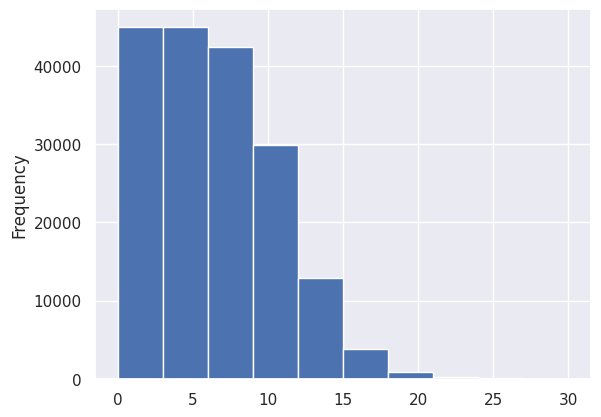

In [ ]:
train_df['line_number'].plot.hist()

In [ ]:
## usinf tf for one hot encoding number?
train_df_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth = 15)
val_df_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth = 15)
test_df_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth = 15)
train_df_line_number_one_hot[:10],train_df_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [ ]:
## how many total lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

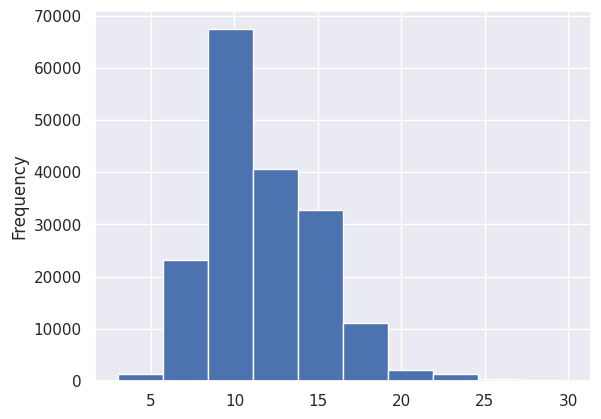

In [ ]:
## PLot hist to check frequency distribution
train_df["total_lines"].plot.hist()

In [ ]:
##
per = np.percentile(train_df.total_lines , 98)
per

20.0

In [ ]:
train_df_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(),depth = 20)
val_df_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(),depth = 20)
test_df_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(),depth = 20)

In [ ]:
train_df_total_lines_one_hot[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

### Building a tribrid embeddingg model
1. create a token level model
2. create a character level model
3. create a model for line number feature
4. create a model for total_line feature
5. combine the outputs of model 1 and 2 usning `tf.keras.layers.Concatenate`
6. combine the outputs of model 3,4 and 5 using `tf.keras.layers.Concatenate`
7. create an output layer to accept thr tribried embedding an output label probabilities
8. combine the inputs of model 1,2,3,4 and the outputs of into a tf.keras.Modell

In [ ]:
# 1. Token Model
token_inputs = layers.Input(shape=[],dtype = tf.string)
token_embeddings = embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_outputs)

# 2. Setup char/model
char_inputs = layers.Input(shape = [], dtype = tf.string , name = 'Char_input_layer')
char_vectors = char_vectorizer(char_inputs)
char_embedd = char_embedding_layer(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedd)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)


#3. Creating  a model for line number model
line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32 , name ="Line_number_input_layer")
x = layers.Dense(32, activation='relu' )(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)


#4. Creatig a Total line model
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32 , name ="total_lines_input_layer")
y = layers.Dense(32, activation='relu' )(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = y)


# 5. Combining the outputs of MODEL (1,2)
combined_embeddings= tf.keras.layers.Concatenate(name = "token_char_concatenate_layer")([token_model.output,
                                                                                    char_model.output])
#6
z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z= layers.Dropout(0.5)(z)



#7. combine the outputs of model 3,4 and 5
tribrid_embeddings = tf.keras.layers.Concatenate(name = "tribrid_postional_embedding_layer")([line_number_model.output,
                                                                                              total_lines_model.output,
                                                                                              z])


output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer)

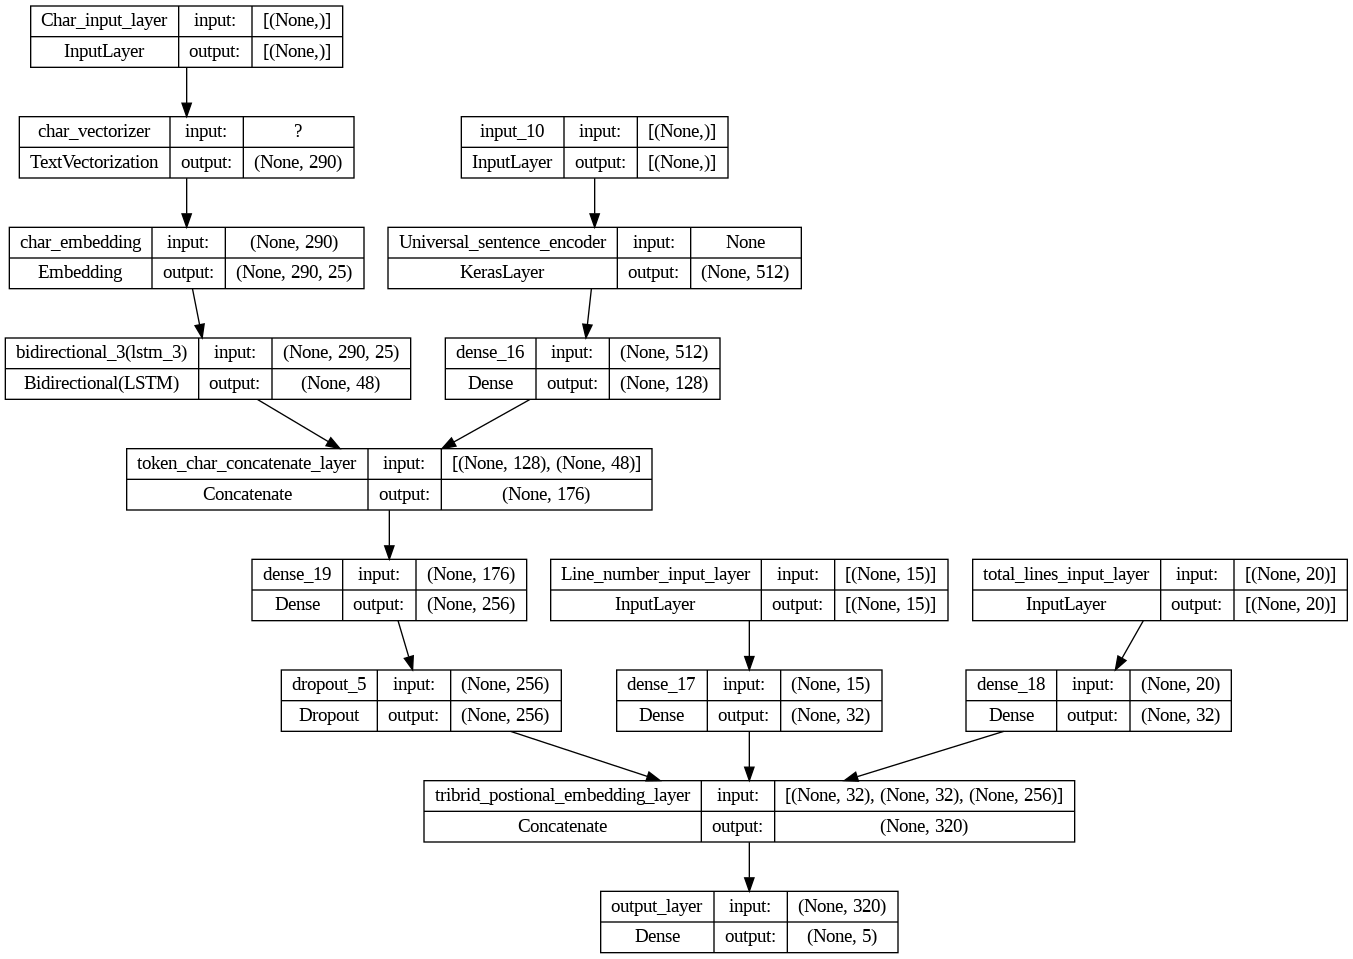

In [ ]:
plot_model(model_5,show_shapes = True)

In [ ]:
model_5.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Char_input_layer (InputLay  [(None,)]                    0         []                            
 er)                                                                                              
                                                                                                  
 input_10 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['Char_input_layer[0][0]']    
 rization)                                                                                        
                                                                                           

In [ ]:
model_5.compile(optimizer = 'adam',
                loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                metrics = ['accuracy'])

### Creating a dataset for model _5

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_df_line_number_one_hot, # line numbers
                                                                train_df_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_one_hot_labels) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_df_line_number_one_hot, # line numbers
                                                                val_df_total_lines_one_hot, # total lines
                                                                val_sentences, # train tokens
                                                                val_chars)) #val char
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_one_hot_labels)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



train_pos_char_token_dataset,val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 59s 56ms/step - loss: 1.0987 - accuracy: 0.7227 - val_loss: 0.9866 - val_accuracy: 0.8002
Epoch 2/3
562/562 [==============================] - 35s 62ms/step - loss: 0.9688 - accuracy: 0.8132 - val_loss: 0.9494 - val_accuracy: 0.8265
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9498 - accuracy: 0.8202 - val_loss: 0.9377 - val_accuracy: 0.8328


In [ ]:

# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs


# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds



945/945 [==============================] - 22s 23ms/step


{'accuracy': 83.4072553952072,
 'precision': 0.8328513855832164,
 'recall': 0.834072553952072,
 'f1': 0.833096765549392}

In [ ]:

# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_label_encoder,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.4072553952072,
 'precision': 0.8328513855832164,
 'recall': 0.834072553952072,
 'f1': 0.833096765549392}

## Compare model results
Far out, we've come a long way. From a baseline model to training a model containing three different kinds of embeddings.

Now it's time to compare each model's performance against each other.

We'll also be able to compare our model's to the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.


In [ ]:


# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": model_0_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.402621,0.780808,0.784026,0.781480
pretrained_token_embed,67.489739,0.670337,0.674897,0.659295
custom_char_embed_conv1d,65.576592,0.652041,0.655766,0.645177
hybrid_char_token_embed,73.841520,0.738038,0.738415,0.735275
tribrid_pos_char_token_embed,83.407255,0.832851,0.834073,0.833097


In [ ]:


# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

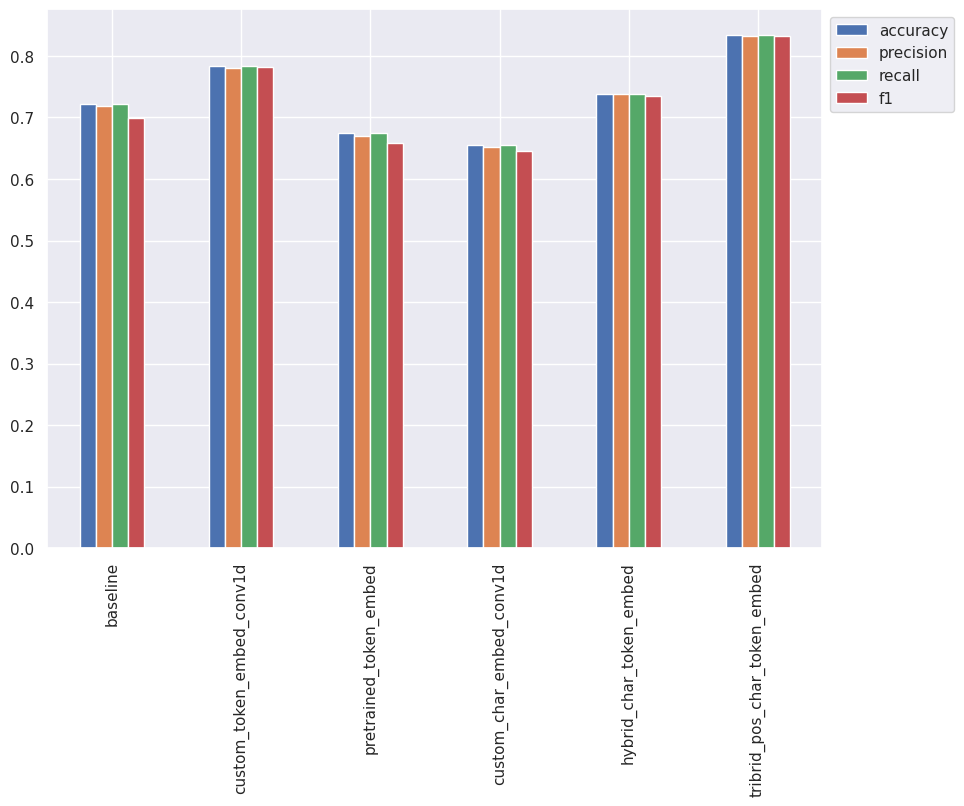

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

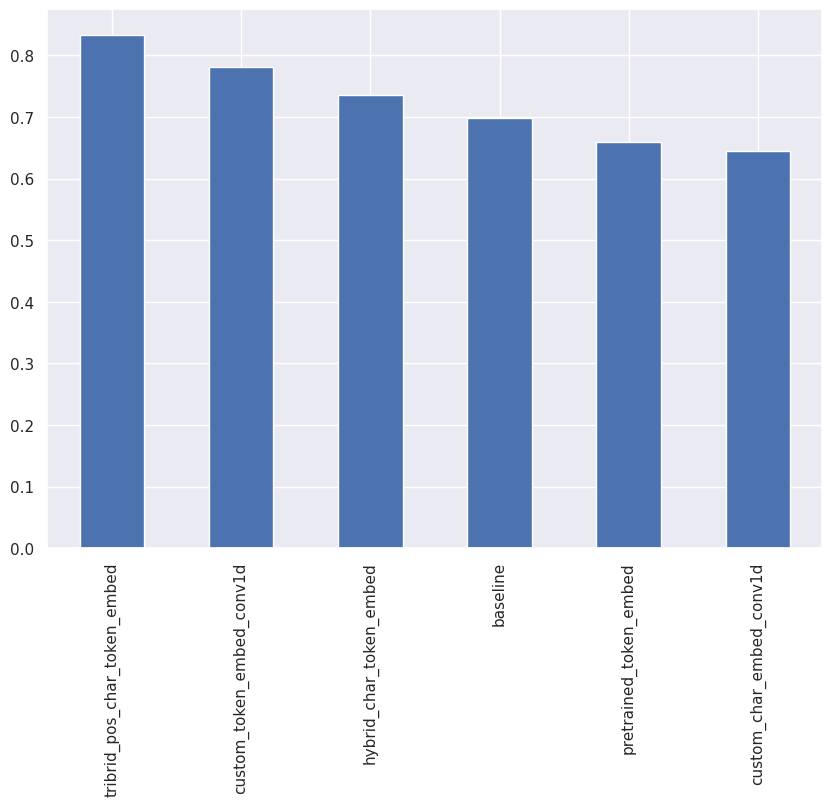

In [ ]:

# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load best performing model
Since we've been through a fair few experiments, it's a good idea to save our best performing model so we can reuse it without having to retrain it.

We can save our best performing model by calling the save() method on it.




In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("/content/drive/MyDrive/skimlit_tribrid_model") # model will be saved to path specified by string

In [ ]:
!wget = https://drive.google.com/file/d/1XjXbt9sP0XcBXhPZV_6anVAycqhSVVsK/view?usp=drive_link

--2023-09-20 11:19:03--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2023-09-20 11:19:03--  https://drive.google.com/file/d/1XjXbt9sP0XcBXhPZV_6anVAycqhSVVsK/view?usp=drive_link
Resolving drive.google.com (drive.google.com)... 108.177.120.139, 108.177.120.102, 108.177.120.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.120.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&osid=1&continue=https://drive.google.com/file/d/1XjXbt9sP0XcBXhPZV_6anVAycqhSVVsK/view?usp%3Ddrive_link&followup=https://drive.google.com/file/d/1XjXbt9sP0XcBXhPZV_6anVAycqhSVVsK/view?usp%3Ddrive_link [following]
--2023-09-20 11:19:03--  https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&osid=1&continue=https://drive.google.com/file/d/1XjXbt9sP0XcBXhPZV_6anVAycqhSVVsK/view?usp%3Ddrive_link&followup=https:/

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/skimlit_tribrid_model')

In [ ]:
new_model.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 44s 39ms/step - loss: 0.9358 - accuracy: 0.8341


[0.9357655048370361, 0.8340725302696228]

In [ ]:
new_model_preds = new_model.predict(val_pos_char_token_dataset)
new_model_preds = tf.argmax(new_model_preds, axis = 1)

945/945 [==============================] - 22s 24ms/step


In [ ]:
new_results = calculate_results(y_true=val_label_encoder,
                                    y_pred=new_model_preds)
new_results == model_5_results

True

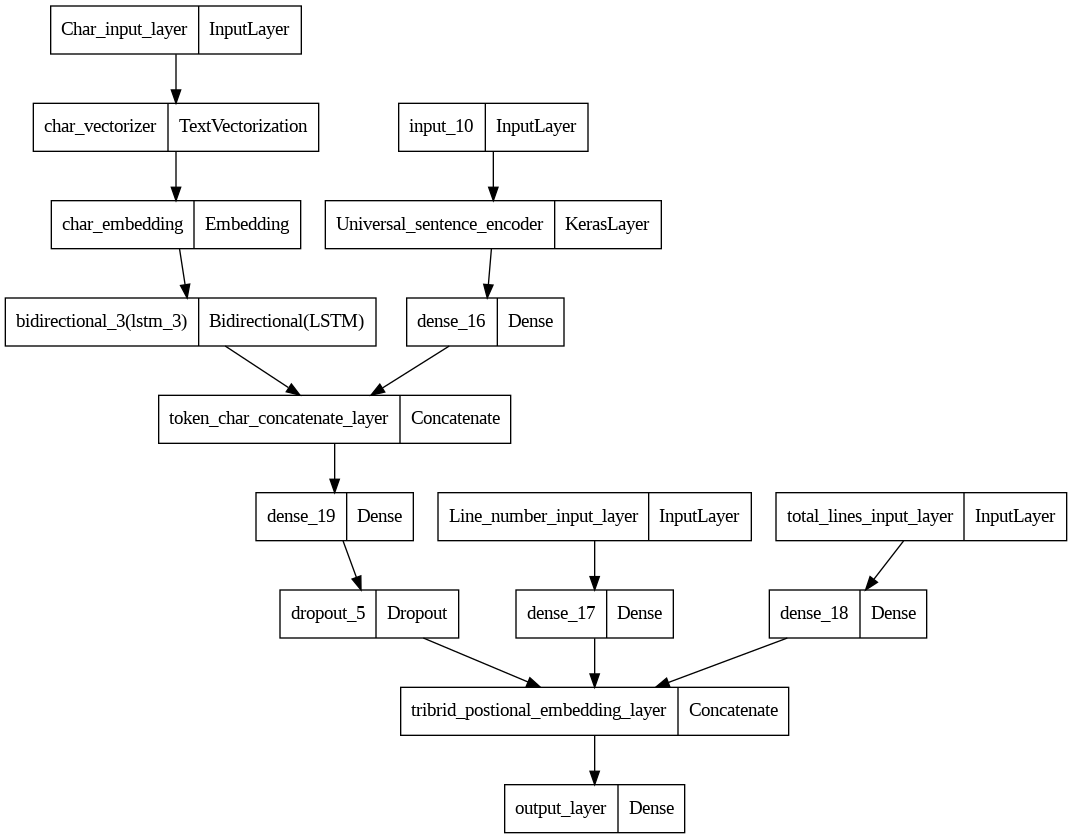

In [ ]:
plot_model(new_model)